## What is a limit order book (LOB)?
A LOB is the set of all active orders in a market at a given time. It is essentially a data structure that contains all the orders sent to the market, with their characteristics: sign of the order (buy or sell), price, volume, timestamp etc. So it contains, at any given point in time, on a given market, the list of all the transactions that one could possibly perform on this market.

<p align="center">
<img src="figures/LOB.png"  width="600"/> </p>

The main idea is that trades occur when orders of different sides match their prices: a side takes on the role of the *aggressor* at a given price, and if there is a resting order, i.e. *limit* order, on the other side at the same price the trade happens.

Therefore, since bidders want to buy at the lower possible price, the most appealing order for a bidder is the level of the ask side corresponding to the lower price. On the other hand, traders on the ask side want to sell at the highest price, thus the most appealing trades correspond to the highest price on the bid side.

### Types of orders
Essentially, three types of orders can be submitted:

* **Limit order:** to specify a price at which one is willing to buy or sell a certain number of shares, with their corresponding price and quantity, at any point in time;
* **Market order:** to immediately buy or sell a certain quantity, at the best available opposite quote;
* **Cancellation order:** to cancel an existing limit order.

## How to build a LOB by processing trade messages?

### Messages and volume bars
To build a LOB we should start considering a list of messages in the trade market: every message correspond to a certain action in the market that can modify the structure of the LOB.
We are working on a given list of messages that can be processed by employing the library provided by XSOR Capital: **db_lob**.

The main workflow follows:

1. A message is read in the trade market, and it is cast to the right kind of message;
2. Information about the messages are employed to update the state of the book;
3. Messages are collected until the cumulative traded volumes
exceed a fixed **threshold**;
4. Once the threshold is exceeded a bar is created, and the data inside it gets
aggregated.

The idea behind this approach is that, instead of aggregating data according to a fixed discetization of time or sampling frequency, we aggregate data focusing on the **activity of a security**. This way the threshold value represents the "activity threshold".

Another parameter that is required by the LOB is the tick size. In an order
book, the possible prices at which a security is traded are discrete, the discretization interval is referred as tick size.

In our analysis we fix:

`volume_threshold = 1000000`

`ticksize = 0.0001`

### Studying the time evolution of a LOB

A LOB can be employed to study the time evolution of the market, indeed for each state of the book, a set of features can be extracted and computed.

We provide two different approaches to study the time evolution of the book:

1. Features extraction from each volume bar every time the threshold is exceeded;
2. Features extraction for each message that actually changes the state of the book.

Moreover, we focus on the study of four features that can be extracted by a LOB:

1. Distribution of orders sizes;
2. Order flow imbalance for price prediction;
3. Probability of informed trading;
4. Volatility.


## Distribution of order sizes

An interesting quantity to study is the frequency of trades per trade size, we could use such quantity to observe two different trends:

1. **Trade frequency vs trade size:** we would expect the first to decrease as the second increases, since high price order should be less frequent;

2. **Distribution of more frequent order sizes:**  in general trades with round values (5, 10, 20, 50 and so on) are exceptionally common, because human traders tend to rely on GUIs that provide buttons with round values. Nevertheless, Silicon traders instead prefer to use randomized sizes, thus by studying the distribution of order sizes we could try to infer the nature of the traders.

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

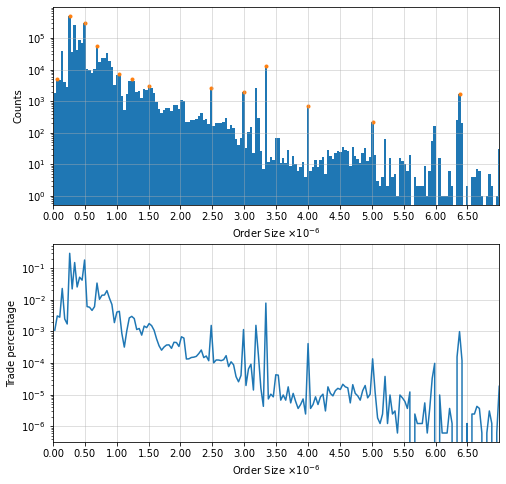

In [8]:
from matplotlib.ticker import StrMethodFormatter
df = pd.read_csv("./data_cleaned/orders.csv")
# Histogram
nbins = int(np.sqrt(df.shape[0])) * 2
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
counts, bins, patches = ax1.hist(df * 10 ** -6, nbins, log=True)
from scipy.signal import find_peaks
# for local maxima
peaks = find_peaks(counts, threshold=200, distance=5)
mid_bins = np.array((bins[1:] + bins[:-1])/2)
ax1.scatter(mid_bins[peaks[0]], counts[peaks[0]],
            color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1],  marker=".")
ax1.set_xlabel("Order Size $\\times 10^{-6}$")
ax1.set_xlim((0, 7))
ax1.set_yscale("log")
ax1.grid(alpha=0.5)
ax1.set_ylabel("Counts")
ax1.set_xticks([x * .5 for x in range(14)])
ax1.xaxis.set_major_formatter(StrMethodFormatter('{x:1.2f}'))
# Trade percentage
total_volume = counts.sum()
pcts = np.array([])
for vol in counts:
    pcts = np.append(pcts, vol/total_volume)
ax2.plot(mid_bins, pcts)
ax2.set_xlabel("Order Size $\\times 10^{-6}$")
ax2.set_xlim((0, 7))
ax2.set_yscale("log")
ax2.grid(alpha=0.5)
ax2.set_ylabel("Trade percentage")
ax2.set_xticks([x * .5 for x in range(14)])
ax2.xaxis.set_major_formatter(StrMethodFormatter('{x:1.2f}'))
plt.show()

## Order flow imbalance

The LOB can be used to see how the shift in orders volumes and prices can give information about the future movement of prices. In particular, the Order flow imbalance (OFI) and its multi-level counterpart Multi Level OFI (MLOFI), may be employed as a price predictor.
For instance, if we consider the first level of the book informally define the order flow imbalance as the imbalance between demand and supply at the best bid and ask prices. Thus, it has an explanatory power of the traders' intentions.


The formal definition follows:

<p align="center">
<img src="figures/OFI.png"  width="900"/> </p>

where b_m(t) and a_m(t) are respectively bid and ask prices at level m at time t and r_m(t) and q_m(t) are the corresponding volumes.

Let us now consider as an examples how the LOB evolves if we consider it up to the second level:

<p align="center">
<img src="figures/OFI_ex1.png"  width="800"/> </p>

<p align="center">
<img src="figures/OFI_ex2.png"  width="800"/> </p>

### OFI computation
OFI preprocessing and computation is carried out in `order_flow_imbalance/ofi_computation.py` by following the steps below.
1. Clean timestamps according to the date of acquisition: we consider only meaningful timestamps that are within the same day of acquisition.
2. Rescaling prices with the tick size;
3. Compute the quantities $\Delta W$ and $\Delta V$ for each timestamp;
4. Discretizig time and summing the single $e_n$ over the time interval in order to compute OFI, we fix a time interval of 1 min.

In [2]:
ofi = pd.read_csv('data_cleaned/ofi_10_levels.csv')
OFI_values = ofi.drop(['mid_price_delta', 'time_bin', 'bin_label'], axis=1)

### Distributions
First of all, let us have a look at the time distributions of MLOFI at different levels. The plot below and further analysis suggest that the distributions of MLOFI are quite similar at different levels and that every level is characterized by the presence of outliers which are significantly distant from the mean.

The first observation can be formalized by means of a Kolmogorov-Smirnov test with two samples, while the second observation justifies the usage of a strategy to get rid of outliers that could be present in the distributions.

Text(0, 0.5, 'OFI value')

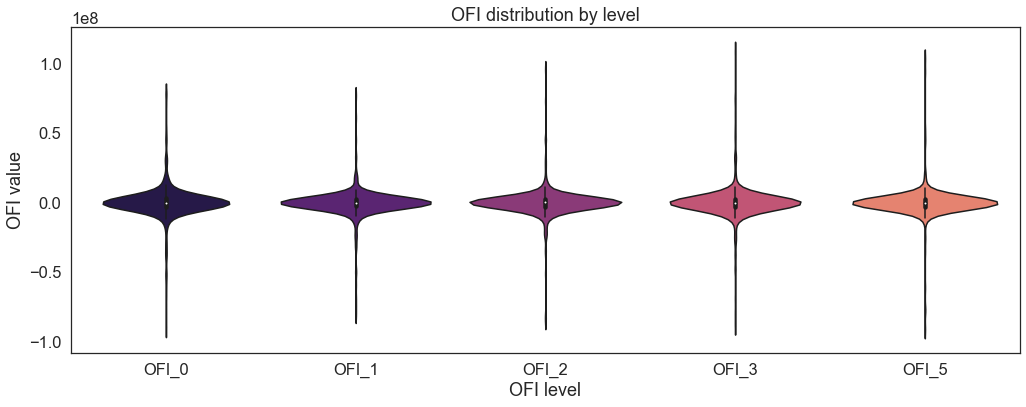

In [3]:
sns.set_theme(style='white', font_scale=1.5, palette = 'magma')
fig, ax = plt.subplots(figsize=(17,6))
df_distr = OFI_values.copy()
df_distr = df_distr.drop(['OFI_9', 'OFI_8', 'OFI_7', 'OFI_6', 'OFI_4'], axis=1)
categorical_ofi = []
levels = []
for c in df_distr.columns:
    categorical_ofi = np.concatenate([categorical_ofi, OFI_values[c]])
    levels = np.concatenate([levels, np.repeat(c, OFI_values.shape[0])])
cat_ofi = pd.DataFrame({'OFI':categorical_ofi, 'level':levels})

sns.violinplot(data=cat_ofi, x='level',y='OFI', ax=ax)
ax.set_title('OFI distribution by level')
ax.set_xlabel('OFI level')
ax.set_ylabel('OFI value')

OFI 0 vs OFI 1: KS distance: 0.05 	 p_value: 0.47
OFI 0 vs OFI 2: KS distance: 0.06 	 p_value: 0.26
OFI 0 vs OFI 3: KS distance: 0.05 	 p_value: 0.67
OFI 0 vs OFI 4: KS distance: 0.06 	 p_value: 0.30
OFI 0 vs OFI 5: KS distance: 0.06 	 p_value: 0.38


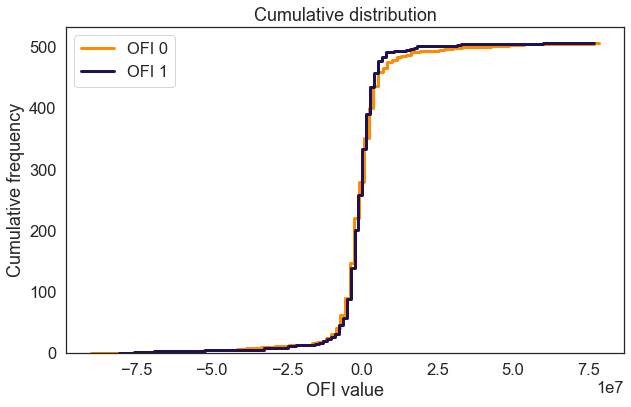

In [4]:
from scipy.stats import ks_2samp

# 0 vs 1
print('OFI 0 vs OFI 1: KS distance: {:.2f} \t p_value: {:.2f}'.format(*ks_2samp(OFI_values['OFI_0'], OFI_values['OFI_1'])))
# 0 vs 2
print('OFI 0 vs OFI 2: KS distance: {:.2f} \t p_value: {:.2f}'.format(*ks_2samp(OFI_values['OFI_0'], OFI_values['OFI_2'] )))
# 0 vs 3
print('OFI 0 vs OFI 3: KS distance: {:.2f} \t p_value: {:.2f}'.format(*ks_2samp(OFI_values['OFI_0'], OFI_values['OFI_3'])))
# 0 vs 4
print('OFI 0 vs OFI 4: KS distance: {:.2f} \t p_value: {:.2f}'.format(*ks_2samp(OFI_values['OFI_0'], OFI_values['OFI_4'])))
# 0 vs 5
print('OFI 0 vs OFI 5: KS distance: {:.2f} \t p_value: {:.2f}'.format(*ks_2samp(OFI_values['OFI_0'], OFI_values['OFI_5'])))

fig, ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='white', font_scale=1.5, palette = 'magma')
lw=3
sns.histplot(data=ofi, x='OFI_0', ax=ax, cumulative=True, element = 'step', fill=False, linewidth=lw, label='OFI 0', color='darkorange')
sns.histplot(data=ofi, x='OFI_1', ax=ax, cumulative=True, element = 'step', fill=False, linewidth=lw, label='OFI 1')
ax.set_title('Cumulative distribution')
ax.set_xlabel('OFI value')
ax.set_ylabel('Cumulative frequency')
ax.legend()

### Outlier detection with Isolation Forest and Linear Fit
The OFI, can be a good price predictor since it has been shown (Cont et al., (2011)) that it stands in a linear relation with the midprice, thus with the price at which it is more likely that a trades occur. 

$$ \Delta P_k = \beta \,\, OFI_k + \epsilon$$

where $ \Delta P_k $ is the variation in price at time $\tau_k$, $\beta$ is the price impact coefficient, $OFI_k$ is the order flow imbalance at time $\tau_k$, and $\epsilon$ is the error term.

Here we study not only the first level of the book, but all the first six levels, in order to verify if such linear relation holds for the whole book.

Fitting level 0
Fitting level 1
Fitting level 2
Fitting level 3
Fitting level 4
Fitting level 5


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

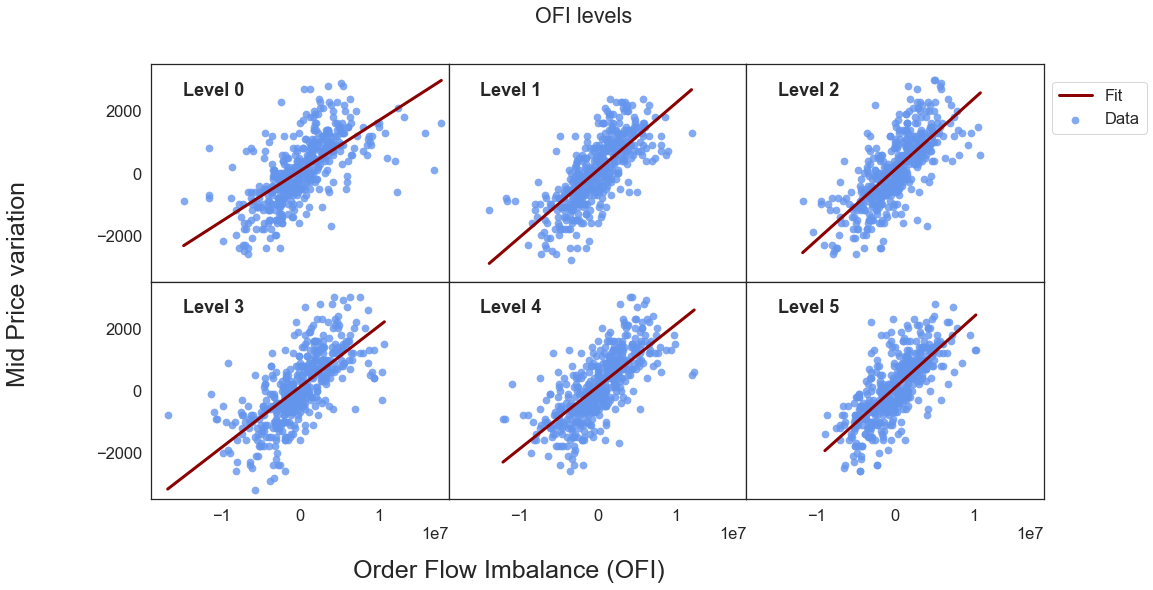

In [5]:
from sklearn.ensemble import IsolationForest
n_fit = 6
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
sns.set_theme(style='white', font_scale=1.5)
j=0
k=0
a_coeff, b_coeff, r2_scores  = [], [], []
for i in range(n_fit):
    print('Fitting level {}'.format(i))
    if i==3: 
        j=0
        k=1
    #removing outliers 
    trend_data = np.array([ofi['OFI_{}'.format(i)], ofi['mid_price_delta']], dtype=np.float64).T
    clf = IsolationForest(n_estimators=100)
    clf.fit(trend_data)   
    outliers = [True if x==1 else False for x in clf.predict(trend_data)]
    trend_data=trend_data[outliers].T

    # linear fit
    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score, mean_squared_error
    model=Ridge()
    model.fit(trend_data[0].reshape(-1,1),trend_data[1])
    a, b = model.coef_[0], model.intercept_
    a_coeff.append(a)
    b_coeff.append(b)
    # r2_score: proportion of the variation in the dependent 
    # variable that is predictable from the independent variable
    r2_scores.append((r2_score(trend_data[1], model.predict(trend_data[0].reshape(-1,1)))))

    #plot
    predicted=[a*x+b for x in trend_data[0]]
    sns.scatterplot(x=trend_data[0], y=trend_data[1], ax=ax[k,j], \
                    s=60, marker='o', color ='cornflowerblue',linewidth=0, alpha=0.8, label='Data')
    g=sns.lineplot(x=trend_data[0], y=predicted, ax=ax[k,j], lw=3, color='darkred', label='Fit')

    g.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    if k!=0 and j!=0: ax[k,j].get_legend().remove()
    ax[k,j].set_xlabel('')
    ax[k,j].set_ylabel('')
    ax[k,j].set_xlim(-1.9e7, 1.9e7)
    ax[k,j].set_ylim(-3500, 3500)
    ax[k,j].text(-1.5e7, 2500, 'Level {}'.format(i), weight='bold')
    j+=1

#Options for the plot
fig.suptitle('OFI levels')
ax[0,0].get_shared_x_axes().join(ax[0,0], ax[1,0])
ax[0,0].set_xticklabels([])
ax[0,1].set_yticklabels('')
ax[1,1].set_yticklabels('')
ax[1,2].set_yticklabels('')
ax[0,2].set_yticklabels('')

fig.text(0, 0.5, 'Mid Price variation', rotation=90, va='center', fontsize=25)
fig.text(0.3, 0, 'Order Flow Imbalance (OFI) ', va='center', fontsize=25)
fig.subplots_adjust(hspace=.0, wspace=0.)

#output
import os 
if os.path.isdir('../figures')==False:
    os.mkdir('../figures')
fig.savefig('../figures/OFI_levels_fit.png', bbox_inches='tight')

#results
from IPython.display import display, Math
for i in range(n_fit): 
    display(Math(r'Level \,\,{} \quad \quad  \Delta \overline P = {:.4f}\,\, OFI_{} + {:.4f}'.format(i, a_coeff[i], i, b_coeff[i])+
            '\quad R^2 = {:.2f}'.format(r2_scores[i])))

### Multi dimensional linear fit

Now that we verified that a linear relation occurs, even though the quality of the fit does not allow us to descrie all the variance of the mid price in the book, we can use the same procedure to study the OFI in the first ten levels of the book by applying a multi dimensional linear fit. Moreover, this same strategy can be also seen as the definition of a new feature as the linear combination of the multi-level OFIs.

So we propose two strategies:

1. We apply the startegy proposed by K. Xu, M. D. Gould, and S. D. Howison (Multi-Level Order-Flow Imbalance in a Limit Order Book), which consist in a multi-dimensional linear fit by means of Ridge regression of the OFI in the first ten levels of the book:$$\Delta  P_k = \alpha+ \sum_m \beta_m OFI_m^k$$
    where $P_k $ is defined as before, and OFI_m^k$ is the OFI in the $m^{th}$ level of the book at time $\tau_k$.
    
2. We define a new feature as the weighted sum of the first 10 levels OFI and we optimize the r2 score of a linear regression vs the mid price evolution of such feature. Then the weights are employed to define the feature and to perform a second linear fit: $$ f = \sum_m \beta_m OFI_m $$ $$ \Delta  P = \alpha+ \gamma f $$

The second strategy was employed to test if a multiple optimization performed by combining a gradient based method (sklearn linear regression) with a gradient free approach (powell and cobyla) could lead to better results, nevertheless results are statistically similar to the first strategy. Thus we conclude that the results do not depend on the computational strategy employed, and we can actually describe arounf 40% of the variance of the mid price in the book by means of the OFI.

MULTIDIMENSIONAL LINEAR REGRESSION


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Optimization terminated successfully.
         Current function value: -0.426366
         Iterations: 4
         Function evaluations: 435
OPTIMIZATION COMBINED WITH REGRESSION


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

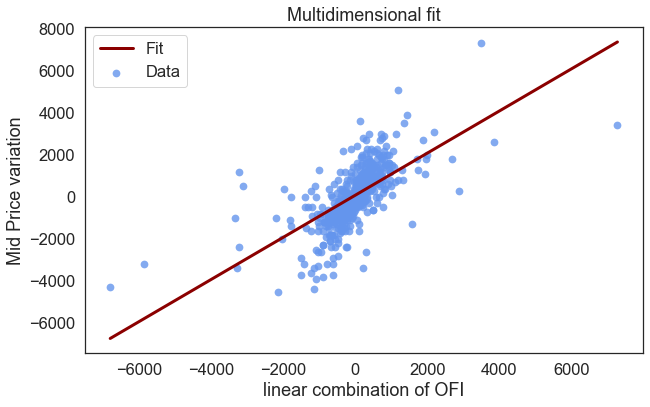

In [6]:
mid_price_delta = ofi['mid_price_delta']

# linear regression with sklearn
from sklearn.linear_model import LinearRegression, Ridge
model=Ridge()
model.fit(OFI_values, mid_price_delta)
betas, alpha = model.coef_, model.intercept_
r2_scores=r2_score(mid_price_delta, model.predict(OFI_values))
print('MULTIDIMENSIONAL LINEAR REGRESSION')
display(Math(r'\Delta P = \alpha+ \sum_m \beta_m OFI_m'))
display(Math(r'\alpha = {:.4f}'.format(alpha)))
display(Math(r'\beta =['+', \,\,'.join(['{:.6f}'.format(b) for b in betas])+']'))
display(Math(r'R^2 = {:.2f}'.format(r2_scores)))

def linear_combination(weights, data):
        """
        args:
            weights (list or np.array): list of weights
            data (list or np.array): list of OFI
        returns:
            linear combination of data
        """
        return sum([w*d for w,d in zip(weights, data)])

sns.set_theme(style='white', font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,6))
new_feature = [linear_combination(betas, OFI_values.iloc[i,:]) for i in range(len(OFI_values))]
sns.scatterplot(x=new_feature, y=mid_price_delta, ax=ax, s=60, marker='o', 
                color ='cornflowerblue',linewidth=0, alpha=0.8, label='Data')
sns.lineplot(x=new_feature, y=alpha+new_feature, ax=ax, lw=3, color='darkred', label='Fit')
ax.set_ylabel('Mid Price variation')
ax.set_xlabel('linear combination of OFI')
ax.set_title('Multidimensional fit')


# optimization of the new feature 
def loss(weights, data_ofi, mid_price_delta):
    """
    args:
        weights: list of weights
        data_ofi: list of OFI
        mid_price_delta: list of mid price delta
    returns:
        loss of linear combination of data
    """

    if len(weights)!=len(data_ofi.columns):
        raise ValueError('weights and data_ofi.columns must have the same length')
    if len(data_ofi)!=len(mid_price_delta):
        raise ValueError('data_ofi and mid_price_delta must have the same length')

    new_feature = np.array([linear_combination(weights, data_ofi.iloc[i,:]) for i in range(len(data_ofi))])

    # We optimize over tthe weights once we defined a new feature which is the weighted sum of the OFI
    # objective is the r2 score of the linear fit

    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(new_feature.reshape(-1,1), mid_price_delta)
    r2 = r2_score(mid_price_delta, model.predict(new_feature.reshape(-1,1)))
    return -r2

from scipy.optimize import minimize
r = minimize(loss, x0=np.random.uniform(size=10), args=(OFI_values, mid_price_delta), 
        method='powell', bounds=[(0, None) for i in range(10)], options={'disp': True})

weights = r.x
new_feature = np.array([linear_combination(weights, OFI_values.iloc[i,:]) for i in range(len(OFI_values))])

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(new_feature.reshape(-1,1), mid_price_delta)
r2 = r2_score(mid_price_delta, model.predict(new_feature.reshape(-1,1)))
alpha = model.intercept_
betas = weights
gamma = model.coef_

print('OPTIMIZATION COMBINED WITH REGRESSION')
display(Math(r'\Delta  P = \alpha+ \gamma \sum_m \beta_m OFI_m'))
display(Math(r'\alpha = {:.4f}'.format(alpha)))
display(Math(r'\gamma = {:.5f}'.format(*gamma)))
display(Math(r'\beta =['+', \,\,'.join(['{:.6f}'.format(b) for b in betas])+']'))
display(Math(r'\beta*\gamma =['+', \,\,'.join(['{:.6f}'.format(b*gamma[0]) for b in betas])+']'))
display(Math(r'R^2 = {:.2f}'.format(r2)))

### PCA and correlations

Finally, since we verified that different levels of the book exhibit the same relation with the mid price time evolution, we would expect to observe correlations within different OFI. 

To formalize this, we can use the PCA to study the correlation between the OFI in the first ten levels of the book.
We then provide the correlation matrix, and the explained variance of the principal components computed after applying PCA to the data. 
We can deduce that the first four levels tend to be more correlated if compared with higher levels, while lower levels of correlations are observed in the rest of the book. The analysis of the explained variance ratio also shows that in order to explain at least the 80% of the variance of the data we should consider at least four components in the eigenvalues space.

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(634.1681818181817, 0.5, 'Explained variance')

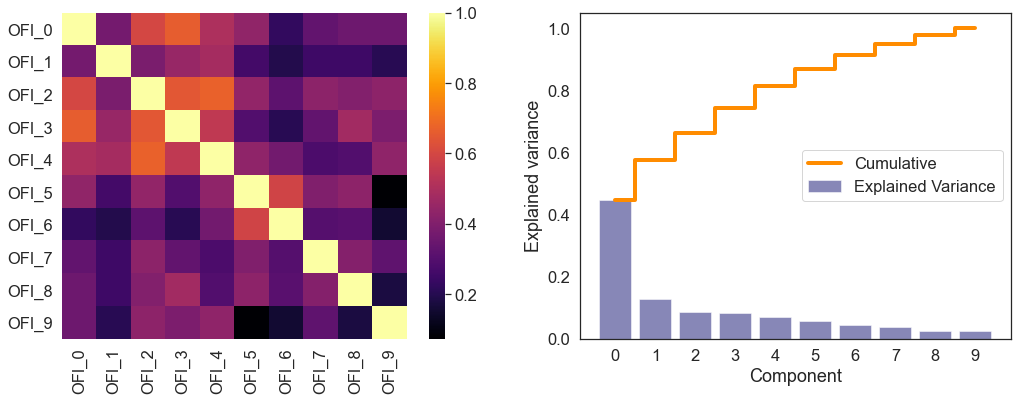

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
scaled = scaler.fit_transform(OFI_values) 
pca = PCA(n_components=None)
pca.fit(scaled)
new_ofi = pca.transform(scaled)

sns.set_theme(style='white', font_scale=1.5, palette = 'magma')
explained_var = pca.explained_variance_ratio_
fig, ax = plt.subplots(1,2, figsize=(17,6))

sns.barplot(np.arange(len(explained_var)), explained_var, alpha=0.5, color = 'navy', ax=ax[1], label='Explained Variance')
ax[1].step(np.arange(len(explained_var)), np.cumsum(explained_var),\
         drawstyle='steps-pre', color='darkorange', lw=4, where = 'mid', label='Cumulative')
plt.legend(loc='center right')
sns.heatmap(OFI_values.corr(), cmap='inferno', fmt='.1f', ax=ax[0])#annot=True
ax[1].set_xlabel('Component')
ax[1].set_ylabel('Explained variance')

## Probability of Informed Trading

The probability of informed trading (PIN) measures how likely it is that some players engage in informed trading, while the rest simply trade randomly.
Such quantity depends on the following parameters:

* alpha: probability that new information will arrive within the timeframe of the analysis;
* delta: probability 𝛿 that the news will be bad;
* mu: rate of arrival of informed traders;
* epsilon: rate of arrival of uninformed traders.

<p align="center">
<img src="figures/PIN_params.png"  width="800"/>
</p>

Once these parameters are known it can be computed by applying a maximum likelihood approach:

<p align="center">
<img src="figures/pin_formula.png"  width="180"/>
</p>
where the parameters maximize the product of likelihood computed on each interval of time. Thus, we discretize time, for each interval we compute the following quantity, as a superposition of poisson PMF:
<p align="center">
<img src="figures/pin_likelihood.png"  width="800"/>
</p>
and then we optimize the product of all the likelihoods on the whole day.

### PIN computation
To compute the PIN of a given day, we need to  optimize the product of the likelihood computed on each time interval in the day.
In particular we fix a time interval of 5 minutes to discretize time, and since we are dealing with the dta of a single trade day we only comppute the corresponding PIN, without further analysis of its time evolution.

Note that this problem must be approached by taking particular care about the optimization method choosen. We tested all the methods from scipy.optimize.minimize for bounded problems, both gradient-based and gredient-free, but most of the results exhibited high dependence on the initial guess for the set of parameters. We then choose to apply powell method, which is a gradient-free method, since it is the only one which actually exhibits an evolution and results to be unbiased by the initial point.


In [8]:
def likelihood(x, bid, ask, T): #x = [alpha, delta, eps, mu]
    """
    likelihood function for the model
    args:
        x: parameters of the model
        bid: observation of the bid side
        ask: observation of the ask side
        T: time bins
    """
    #compute likelihood with Ealsy's (15) notation
    from scipy.stats import poisson
    likelihood = (1-x[0])*poisson.pmf(k=bid,mu=x[2]*T)*poisson.pmf(k=ask,mu=x[2]*T)+\
                +x[0]*x[1]*poisson.pmf(k=bid,mu=x[2]*T)*poisson.pmf(k=ask,mu=(x[2]+x[3])*T)+\
                +x[0]*(1-x[1])*poisson.pmf(k=bid,mu=(x[2]+x[3])*T)*poisson.pmf(k=ask,mu=x[2]*T)
    return likelihood

def loss (x, bid, ask, T):
    """
    loss function for the model
    args:
        x: parameters of the model (to train)
        bid: list of observations of the bid side
        ask: list of observations of the ask side
        T: time bin width (assumed the same for each bin)
    """
    prod=[]
    #restricting the loss function to values which do not kill the output
    for b, a in zip(bid, ask):
        l=likelihood(x, b, a, T)
        if l>0: prod.append(l)
        else: continue
    return -np.prod(prod)

In [9]:
from scipy.optimize import minimize
from tqdm import tqdm
from datetime import timedelta
time_delta = timedelta(minutes=1)

occurrences = pd.read_csv("data_cleaned/occurrences.csv")
np.random.seed(0)
r=minimize(loss, x0=np.random.uniform(size=4),#
                args=(occurrences['bid_observations'], occurrences['ask_observations'], time_delta.total_seconds()),
                method='powell', bounds=[(0, 1), (0, 1), (0, None), (0, None)])

In [10]:
params = {'alpha': r.x[0], 'delta': r.x[0], 'eps': r.x[0], 'mu': r.x[0]}
PIN = params['alpha']*params['mu']/(params['alpha']*params['mu']+2*params['eps'])

print('PIN: {:.2f}'.format(PIN))
print('alpha: {:.2f}'.format(params['alpha']))
print('delta: {:.2f}'.format(params['delta']))

PIN: 0.24
alpha: 0.64
delta: 0.64


### Volatility

The volatility of an asset provides some indication of how risky it is. All else held equal, an asset with higher volatility is expected to undergo larger price changes than an asset with lower volatility.

We can estimate the probability by noting the price returns at either regular time intervals or every *n* market orders. The second option would allow us to compare volatilities of assets with different sampling frequencies. We define the *realized volatility per trade*:

<p align="center">
<img src="figures/Volatility.png"  width="900"/> </p>

Thus, we estimate the volatility of both sides at the 1st level of the book.

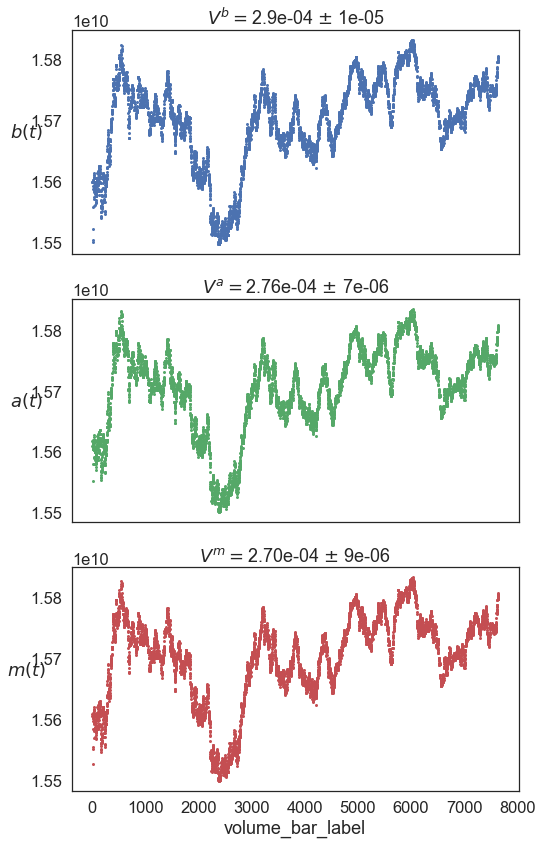

In [14]:
from matplotlib.ticker import StrMethodFormatter
import scipy.stats as t

plt.style.use("seaborn-deep")
df = pd.read_csv("data_cleaned/time_evolution_10_levels.csv")

def std_std(sample):
    n = len(sample)
    mu = t.moment(sample, moment=4)
    return (((mu - sample.std() ** 4) / n) ** 0.5) / (2 * sample.std())

bid_price_series = df['bid_price_0']
ask_price_series = df['ask_price_0']
mid_price_series = df["mid_price"]
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 14))
ax1.scatter([t for t in range(len(bid_price_series))], bid_price_series, marker=".", linewidth=0,
            color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plt.xlabel("volume_bar_label")
ax1.set_ylabel("$b(t)$", rotation=0)
bid_volatility = np.log(np.array(bid_price_series[1:])/np.array(bid_price_series[:-1]))
bid_volatility_error = std_std(bid_volatility)
ax1.set_title(f"$V^b = ${bid_volatility.std():.1e} $\pm$ {bid_volatility_error:.0e}")
ax2.scatter([t for t in range(len(ask_price_series))], ask_price_series, marker=".", linewidth=0,
            color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
ax2.set_ylabel("$a(t)$", rotation=0)
ask_volatility = np.log(np.array(ask_price_series[1:])/np.array(ask_price_series[:-1]))
ask_volatility_error = std_std(ask_volatility)
ax2.set_title(f"$V^a = ${ask_volatility.std():.2e} $\pm$ {ask_volatility_error:.0e}")
ax3.scatter([t for t in range(len(mid_price_series))], mid_price_series, marker=".", linewidth=0,
            color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
ax3.set_ylabel("$m(t)$", rotation=0)
mid_volatility = np.log(np.array(mid_price_series[1:])/np.array(mid_price_series[:-1]))
mid_volatility_error = std_std(mid_volatility)
ax3.set_title(f"$V^m = ${mid_volatility.std():.2e} $\pm$ {mid_volatility_error:.0e}")
plt.show()

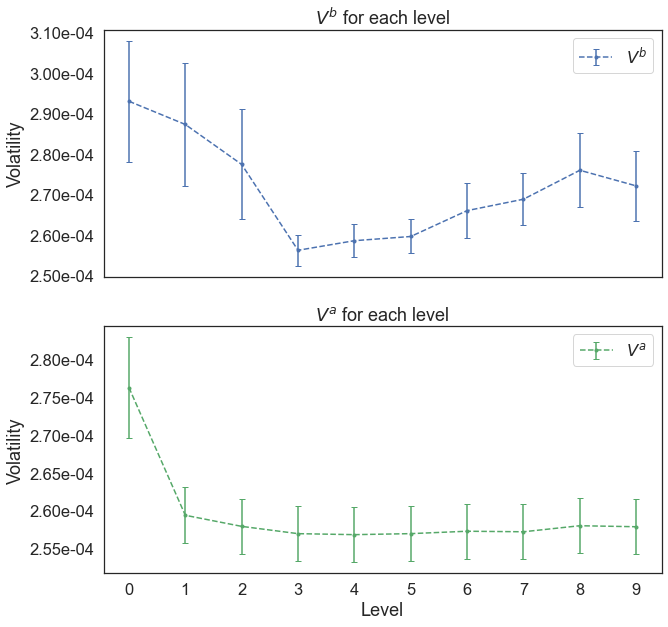

In [16]:
bid_volatility = []
ask_volatility = []
bid_volatility_error = []
ask_volatility_error = []
for level in range(10):
    bid_price_series = df.groupby("volume_bar_label")['bid_price_{}'.format(level)].min()
    ask_price_series = df.groupby("volume_bar_label")['ask_price_{}'.format(level)].max()
    bid_volatility.append(np.log(np.array(bid_price_series[1:])/np.array(bid_price_series[:-1])))
    bid_volatility_error.append(std_std(bid_volatility[level]))
    bid_volatility[level] = np.std(bid_volatility[level])
    ask_volatility.append(np.log(np.array(ask_price_series[1:])/np.array(ask_price_series[:-1])))
    ask_volatility_error.append(std_std(ask_volatility[level]))
    ask_volatility[level] = np.std(ask_volatility[level])

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2e}'))
ax1.errorbar(range(10), bid_volatility, bid_volatility_error, label="$V^b$", marker=".", capsize=3.0, fmt="--",
             color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
ax1.set_title("$V^b$ for each level")
plt.xlabel("Level")
ax1.set_ylabel("Volatility")
ax1.set_xticks(range(10))
ax1.legend()
ax2.errorbar(range(10), ask_volatility, ask_volatility_error, label="$V^a$", marker=".", capsize=3.0, fmt="--",
             color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
ax2.legend()
ax2.set_title("$V^a$ for each level")
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2e}'))
ax2.set_ylabel("Volatility")
ax2.set_xticks(range(10))
plt.show()

## Resources
[1] *The Price Impact of Order Book Events*, R. Cont, A. Kukanov, S. Stoikov (2013)

[2] *Multi-Level Order-Flow Imbalance in a Limit Order Book*, K. Xu, M. D. Gould, and S. D. Howison

[3] *Advances in Financial Machine Learning*, Lopez de Prado (2018), chapter 19.5.1.

[4] *Liquidity, Information, and Infrequently Traded Stocks*, D. Easley et al. (1996), The Journal of Finance, 51:4, 1405-1436.

[5] *Limit Order Books* F. Abergel, M. Anane, A. Chakraborti, Cambridge University Press

[6] *Quantitative finance for physicist: an introduction*, A B. Schmidt

[7] *Limit Order Books* Martin D. Gould et al. (2013), Quantitative Finance, 13:11, 1709-1742.
